In [1]:
import gzip
import glob
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from tqdm import tqdm

from astropy import units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.stats import mad_std, sigma_clipped_stats, SigmaClip, sigma_clip
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from photutils import datasets, DAOStarFinder, SkyCircularAperture, aperture_photometry, CircularAperture, CircularAnnulus, Background2D, MedianBackground
from photutils.background import Background2D
from photutils.detection import find_peaks
from photutils.utils import calc_total_error
from astropy.visualization import ZScaleInterval
#plotting 
import popsims
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [2]:
FIG_FOLDER='/users/caganze/research/J1624/figures/'
DATA_FOLDER='../data/'

In [3]:
KBAND_IMAG_KEYS=['0172', '0171', '0170']
HBAND_IMAG_KEYS=['0174', '0175', '0176']
JBAND_IMAG_KEYS=['0178', '0179', '0180']

In [4]:
def plot_img(img, ax, vmin=-1000, vmax=1000, cmap='cubehelix'):
    ax.pcolormesh(img, vmin=vmin, vmax=vmax, cmap=cmap)

def read_and_visualize(fil, ax):
    hdu=fits.open(DATA_FOLDER+'/c{}.fits'.format(fil))
    med=np.nanmedian(hdu[0].data.flatten())
    std=np.nanstd(hdu[0].data.flatten())
    plot_img(hdu[0].data, ax, vmin=med-3*std, vmax=med+3*std)
    ax.set(title=fil)
    

def make_a_cutout(img,  npix=100, centroid=(0, 0)):
    px0, py0=centroid

    #grab a box around it
    px1, py1 = np.array([px0, py0])-npix
    px2, py2 = np.array([px0, py0])+npix
    return img[slice(int(px1), int(px2)), slice(int(py1), int(py2))]

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


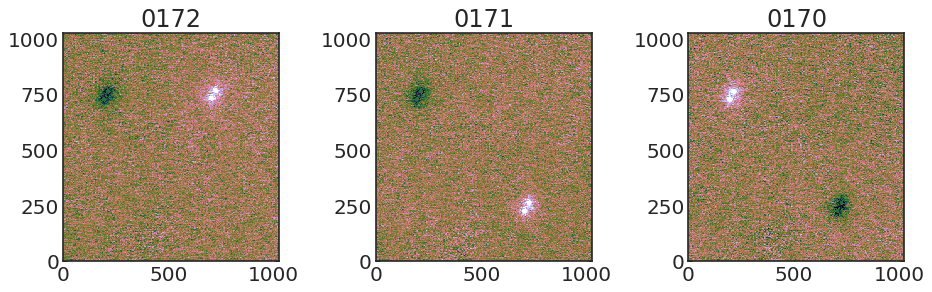

In [5]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
for idx in range(len(KBAND_IMAG_KEYS)):
    read_and_visualize(KBAND_IMAG_KEYS[idx], ax[idx])
plt.tight_layout()

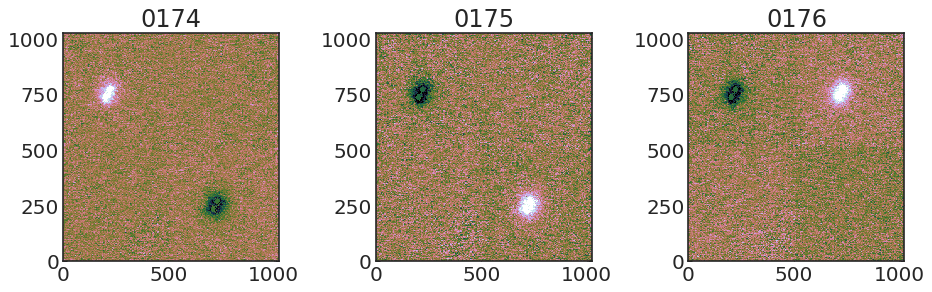

In [6]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
for idx in range(len(HBAND_IMAG_KEYS)):
    read_and_visualize(HBAND_IMAG_KEYS[idx], ax[idx])
plt.tight_layout()

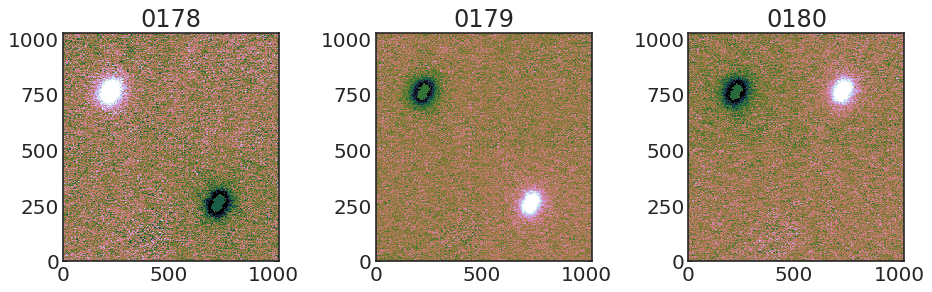

In [7]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))
for idx in range(len(JBAND_IMAG_KEYS)):
    read_and_visualize(JBAND_IMAG_KEYS[idx], ax[idx])
plt.tight_layout()

In [8]:
#some images are flipped
high_centered=['0170', '0174', '0178']
lhigh_centered=['0176', '0180', '0172'] 
lo_centered=['0171', '0179', '0175' ]
other=[]

In [9]:
kimages=dict(zip(KBAND_IMAG_KEYS, [None for x in KBAND_IMAG_KEYS]))
himages=dict(zip(HBAND_IMAG_KEYS, [None for x in HBAND_IMAG_KEYS]))
jimages=dict(zip(JBAND_IMAG_KEYS, [None for x in JBAND_IMAG_KEYS]))

In [10]:
def make_cutouts(images):
    #ported from my previous code
    for k in images.keys():
        cent0=(500+10, 450+20)
        if  k in high_centered:
            cent0= (800-50, 200)
        if k in lhigh_centered:
            cent0=(800-50, 800-60)

        if k in lo_centered:
            cent0=(200+60, 700)

        if k in other:
            cent0=(200+50, 800-60)

        hdu=fits.open(DATA_FOLDER+'/c{}.fits'.format(k))
        cutout=make_a_cutout( hdu[0].data,  npix=200 , \
                             centroid=cent0)
        images[k]=cutout
    return images

In [11]:
kimages=make_cutouts(kimages)
jimages=make_cutouts(jimages)
himages=make_cutouts(himages)

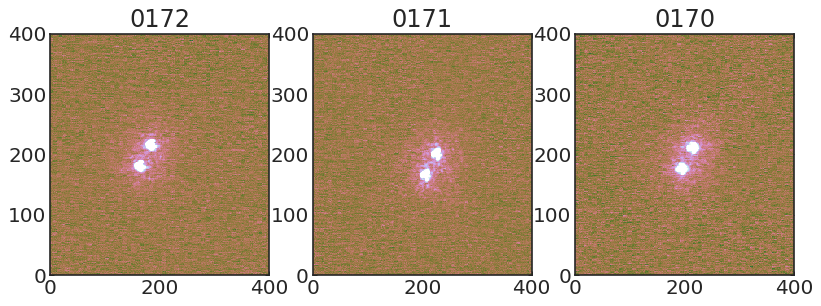

In [12]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

for a, k in zip(ax, kimages.keys()):
    img=kimages[k]
    std=np.nanstd(img)
    med=np.nanmedian(img)
    plot_img(img, a, vmin=med-3*std, vmax=med+3*std)
    a.set(title=k)

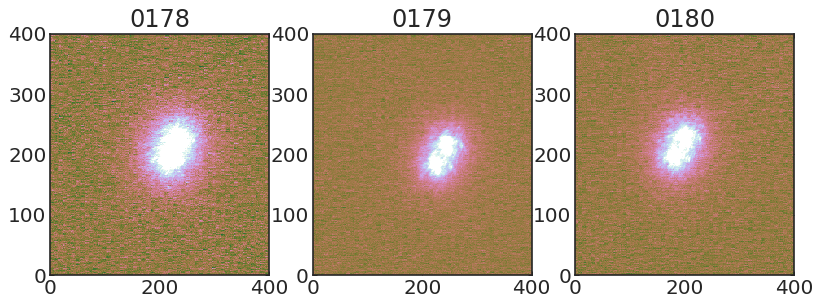

In [13]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

for a, k in zip(ax, jimages.keys()):
    img=jimages[k]
    std=np.nanstd(img)
    med=np.nanmedian(img)
    plot_img(img, a, vmin=med-3*std, vmax=med+3*std)
    a.set(title=k)

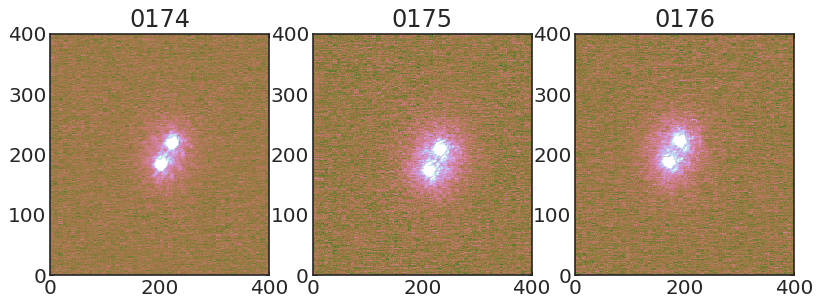

In [14]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 4))

for a, k in zip(ax, himages.keys()):
    img=himages[k]
    std=np.nanstd(img)
    med=np.nanmedian(img)
    plot_img(img, a, vmin=med-3*std, vmax=med+3*std)
    a.set(title=k)

In [15]:
def dao_source_finder(img, sigma=3, fwhm=20.0):
    daofind = DAOStarFinder(fwhm=fwhm, threshold=sigma*np.std(img),\
                            exclude_border=True)
    dao_df=daofind(img)
    if dao_df is not None:
        photometry_table = dao_df.to_pandas()
        return photometry_table
    else:
        print ('Sorry no source found, adjust thereshold')

In [16]:
#porting this from my previous code
def median_combine(comb_df, images, npix=65, plot=True,  combine='median'):
    img=None
    
    #for 
    cutouts=[]
    for g in comb_df.groupby('img'):
        
        #sort by bright object
        data= g[1].sort_values('flux').reset_index(drop=True)
        
        #get image
        image_name= g[0]
        img= images[image_name]
        
        #choose the centroid of the bright object
        cent= list(data[['ycentroid', 'xcentroid']].iloc[0].values)
        
        cutout=make_a_cutout(img,  npix=npix, centroid=tuple(cent))
        cutouts.append(cutout)
  
    cutouts=np.array([x for x in cutouts if np.shape(x)[-1] > 0])

    median=np.nanmedian(cutouts, axis=0)
    
    if combine=='average':
         median=np.nanmean(cutouts, axis=0)
        
    if plot:
        fig, ax=plt.subplots()
        vmin, vmax=ZScaleInterval().get_limits(median)
        plot_img(median, ax, cmap='cubehelix')
    return median

In [17]:
npix=125

In [18]:
#find centroids and median combine
kcomb=[]
for k in KBAND_IMAG_KEYS:
    df=dao_source_finder(kimages[k], sigma=5, fwhm=10.0)
    df['img']=k
    kcomb.append(df)
kcomb_df=pd.concat(kcomb).reset_index(drop=True)
kband=median_combine(kcomb_df, kimages, npix=npix, plot=False,  combine='median')


#find centroids median combine J
jcomb=[]
for k in JBAND_IMAG_KEYS:
    df=dao_source_finder(jimages[k], sigma=5, fwhm=15.0)
    df['img']=k
    jcomb.append(df)
jcomb_df=pd.concat(jcomb).reset_index(drop=True)
jband=median_combine(jcomb_df, jimages, npix=npix, plot=False,  combine='median')

 
#find centroids median combine H
hcomb=[]
for k in HBAND_IMAG_KEYS:
    df=dao_source_finder(himages[k], sigma=5, fwhm=10.0)
    df['img']=k
    hcomb.append(df)
hcomb_df=pd.concat(hcomb).reset_index(drop=True)
hband=median_combine(hcomb_df, himages, npix=npix, plot=False,  combine='median')

In [19]:
final_images=[jband, hband, kband]

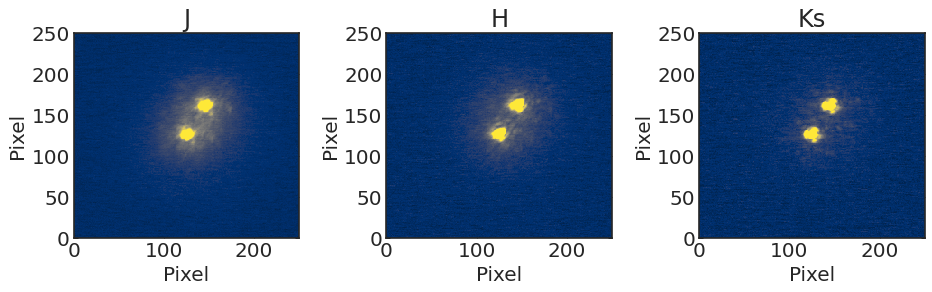

In [20]:
fig, ax=plt.subplots(figsize=(12, 4), ncols=3)

for idx in range(0, 3):
    img= final_images[idx]
    vmin, vmax=ZScaleInterval(contrast=0.05).get_limits(img)
    plot_img(img, ax[idx], vmin=vmin, vmax=vmax,  cmap='cividis')

for a in ax:
    a.set(xlabel='Pixel', ylabel='Pixel')

ax[0].set(title='J')
ax[1].set(title='H')
ax[-1].set(title='Ks')
plt.tight_layout()
plt.savefig(FIG_FOLDER+'/combined_ao_images.jpeg', rasterized=True, bbox_inches='tight')

In [21]:
hcomb_df['band']='H'
jcomb_df['band']='J'
kcomb_df['band']='Ks'

In [22]:
all_data=pd.concat([hcomb_df, jcomb_df, kcomb_df]).reset_index(drop=True)

In [28]:
def get_asep(x1,y1,x2,y2):
    asep = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    return asep

In [44]:
seps=[]
mag_diff=[]
for g in all_data.groupby('img'):
    df0=g[1][g[1].id ==1]
    df1=g[1][g[1].id ==2]
    #compute separation
    cents0=list(df0[['xcentroid', 'ycentroid']].values)
    cents1=list(df1[['xcentroid', 'ycentroid']].values)
    
    
    mag_diff.append(df0.mag.values-df1.mag.values)
    
    seps.append(get_asep( *list(np.concatenate([ cents0,  cents1]).flatten())))

In [45]:
#make measurements
seps

[40.432975883797,
 40.535526514997194,
 40.58019148523097,
 40.510878393219194,
 40.450602441504856,
 40.504833277540314,
 30.89620882906217,
 40.4845446043034,
 40.533505168900426]

In [55]:
all_data

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,img,band
0,1,203.509280,182.983656,0.542537,0.505510,0.167512,169,0.0,5920.364746,24.402658,-3.468593,0174,H
1,2,223.712114,218.097425,0.583642,0.553436,0.182201,169,0.0,6785.613770,27.092330,-3.582116,0174,H
2,1,214.030937,171.971243,0.707537,0.509544,-0.038663,169,0.0,4954.287598,26.619874,-3.563015,0175,H
3,2,234.063499,207.113066,0.708139,0.509669,-0.062531,169,0.0,5269.969727,28.314421,-3.630019,0175,H
4,1,171.931097,186.693483,0.664979,0.686563,0.110799,169,0.0,5122.291992,25.319607,-3.508642,0176,H
5,2,192.113759,221.811878,0.629106,0.674781,0.090534,169,0.0,5247.139160,26.844141,-3.572124,0176,H
6,1,214.794111,192.576836,0.870907,0.450261,-0.272455,361,0.0,2133.547852,14.752268,-2.922147,0178,J
7,2,215.980028,223.450276,0.452409,0.314588,-0.963528,361,0.0,311.856720,1.040253,-0.042847,0178,J
8,3,234.824056,227.574066,0.782061,0.565990,-0.260222,361,0.0,2112.785156,15.825154,-2.998370,0178,J
9,1,224.815443,182.211261,0.901020,0.202439,0.019094,361,0.0,6301.201172,27.818557,-3.610836,0179,J


In [54]:
ms=np.array(mag_diff).flatten()
ms


array([ 0.03774558,  0.03321031,  0.06186428,  0.11352302,  0.06700424,
        0.06348138, -2.87929967,  0.04629681,  0.06559371])

In [48]:
np.nanmedian(seps), np.nanstd(seps)

(40.504833277540314, 3.019773233188461)

In [53]:
ms= [x for x in ms if x >0.]
np.nanmedian(ms), np.nanstd(ms)

(0.06267282940691632, 0.02332348304371877)

In [ ]:
np.nanmedian(seps), np.nanstd(seps)

In [25]:
all_data.to_csv("/Users/caganze/research/J1624/data/nirc2_kai_redued_photJ1624.csv")

In [38]:
all_data

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,img,band
0,1,203.509280,182.983656,0.542537,0.505510,0.167512,169,0.0,5920.364746,24.402658,-3.468593,0174,H
1,2,223.712114,218.097425,0.583642,0.553436,0.182201,169,0.0,6785.613770,27.092330,-3.582116,0174,H
2,1,214.030937,171.971243,0.707537,0.509544,-0.038663,169,0.0,4954.287598,26.619874,-3.563015,0175,H
3,2,234.063499,207.113066,0.708139,0.509669,-0.062531,169,0.0,5269.969727,28.314421,-3.630019,0175,H
4,1,171.931097,186.693483,0.664979,0.686563,0.110799,169,0.0,5122.291992,25.319607,-3.508642,0176,H
5,2,192.113759,221.811878,0.629106,0.674781,0.090534,169,0.0,5247.139160,26.844141,-3.572124,0176,H
6,1,214.794111,192.576836,0.870907,0.450261,-0.272455,361,0.0,2133.547852,14.752268,-2.922147,0178,J
7,2,215.980028,223.450276,0.452409,0.314588,-0.963528,361,0.0,311.856720,1.040253,-0.042847,0178,J
8,3,234.824056,227.574066,0.782061,0.565990,-0.260222,361,0.0,2112.785156,15.825154,-2.998370,0178,J
9,1,224.815443,182.211261,0.901020,0.202439,0.019094,361,0.0,6301.201172,27.818557,-3.610836,0179,J


In [57]:
#dao on combined images
dao_source_finder(jband, sigma=5, fwhm=10.0)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,125.334533,125.494067,0.680589,0.437104,0.018237,169,0.0,4679.566895,11.607174,-2.661816
1,2,145.562201,160.835539,0.597893,0.496705,0.015139,169,0.0,4596.562988,12.197724,-2.715697


In [58]:
dao_source_finder(hband, sigma=5, fwhm=10.0)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,125.625469,125.808225,0.588599,0.602656,0.007049,169,0.0,5122.291992,16.738923,-3.059319
1,2,145.769643,160.927508,0.542643,0.573852,-0.025011,169,0.0,5247.139160,18.099795,-3.144184


In [59]:
dao_source_finder(kband, sigma=5, fwhm=10.0)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1,125.317120,125.688984,0.647079,0.013198,-0.027043,169,0.0,5847.792480,20.162176,-3.261343
1,2,145.612422,160.787068,0.670724,0.098938,-0.008136,169,0.0,6262.688477,21.073590,-3.309346


In [62]:
3.66-3.71

-0.04999999999999982

In [63]:

from platform import python_version

print(python_version())

3.9.7
